Example DECAPS - LSST processing of DECam data

All image data is from NOAO : http://archive.noao.edu 

Catalogs are from https://decaps.rc.fas.harvard.edu/catalogs.html  
    
    


In [41]:
%matplotlib inline

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from astropy.table import Column
from astropy.table import Table
from astropy.coordinates import SkyCoord

from astropy import units as u
from astropy.io import fits
from astropy.table import hstack
from astropy.table import vstack
import os
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

In [16]:
lsstDir = 'LSST_Stack/'
decapsDir = 'DECAPS/'

Read the image database...

In [8]:
image_database = 'imdb.fits'
# download if not yet present
if image_database not in  os.listdir() : 
    print('Downloading the catalog...')
    url = 'http://faun.rc.fas.harvard.edu/decaps/release/imdb.fits'
    urllib.request.urlretrieve(url, image_database)
# read into AstroPy table 
imdb_hdu = fits.open(image_database)
imdb = Table(imdb_hdu[1].data)

In [13]:
# From the image database, figure out names of  DECam visits...
visits = {611980:'g',611529:'r'}

for visit in visits.keys() : 
    cat_name = imdb[imdb['expnum'] == visit]['catfname'].data[0]
    print('The single-band catalog name corresponding to visit %d is %s' %(visit, 
                                                                           cat_name))


The single-band catalog name corresponding to visit 611980 is c4d_170122_055542_ooi_g_v1.cat.fits
The single-band catalog name corresponding to visit 611529 is c4d_170121_055805_ooi_r_v1.cat.fits


Read in the single-epoch DECAPS catalogs...


In [19]:
decaps_data = {}
decaps_hdu_dic = {}
for visit in visits.keys(): 
    cat_name = imdb[imdb['expnum'] == visit]['catfname'].data[0]
    print('\nThe single-band catalog name corresponding \
    to visit %d is %s' %(visit, cat_name))
    file_name  = decapsDir + cat_name
    
    #open the decaps catalog ...
    decaps_hdu = fits.open(file_name)
    band = visits[visit]
    decaps_hdu_dic[band] = decaps_hdu
    # decaps_hdu.info() would display all available tables - 
    # there is a single catalog per CCD, 
    # called 'S21_CAT', etc, based on CCD name. 
    print(visit)
    print(decaps_hdu[0].header['DATE-OBS'])
    print('ra=',decaps_hdu[0].header['RA'],'dec=',decaps_hdu[0].header['DEC'])
    
    # save the zero point for this catalog 
    decaps_zeropoint = decaps_hdu[0].header['MAGZERO']  
    print('For this catalog, zeropoint is ',decaps_zeropoint)
    # only XTENSION   'IMAGE' are the catalogs...
    # since I don't care here to compare exactly ccd-by-ccd to LSST, 
    # I just read in the decaps catalog for all the sources in the
    # full image mosaic. 
    arr = {'decaps_mag':[],'decaps_magerr':[],'ra':[],'dec':[], 'flags':[]}
    decaps_stack = Table(arr, names = ('decaps_mag', 'decaps_magerr',
                                           'ra', 'dec', 'flags'),
                            dtype = ('f8', 'f8','f8', 'f8', 'i8'))

    for i in range(1,len(decaps_hdu[:])) : 
        if 'IMAGE' in decaps_hdu[i].header['XTENSION'] :
            # if the i-th element is image ,
            # the catalog is i+2 element
            ccd_decaps_cat =  Table(decaps_hdu[i+2].data) 
            # convert the fluxes to magnitudes 
            ccd_decaps_cat['decaps_mag'] = -2.5 * np.log10(ccd_decaps_cat['flux'].data) +\
            decaps_zeropoint
            ccd_decaps_cat['decaps_magerr'] = (5.0 / (2*np.log(10))) * \
                ccd_decaps_cat['dflux'].data / ccd_decaps_cat['flux'].data

            # keep only the relevant info
            ccd_decaps = ccd_decaps_cat[['decaps_mag','decaps_magerr',
                                         'ra','dec', 'flags']]
            decaps_stack = vstack([decaps_stack, ccd_decaps])

    decaps_stack.rename_column('ra', 'ra_decaps')
    decaps_stack.rename_column('dec', 'dec_decaps')
    
    # store the catalog for a given filter in a dictionary 
    band  = visits[visit]
    decaps_data[band] = decaps_stack


The single-band catalog name corresponding     to visit 611980 is c4d_170122_055542_ooi_g_v1.cat.fits
611980
2017-01-22T05:53:14.923145
ra= 8:03:32.16 dec= -24:01:54.0
For this catalog, zeropoint is  29.047


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log10



The single-band catalog name corresponding     to visit 611529 is c4d_170121_055805_ooi_r_v1.cat.fits
611529
2017-01-21T05:56:22.142292
ra= 8:03:32.76 dec= -24:01:33.5
For this catalog, zeropoint is  29.388


Now each decaps catalog is an element of a table ... 

In [23]:
decaps_data['g'][:10]

decaps_mag,decaps_magerr,ra_decaps,dec_decaps,flags
float64,float64,float64,float64,int64
19.2154693604,0.0240058153868,120.384850878,-23.0787125518,2
18.7144260406,0.011063140817,120.384893559,-23.0933436216,32
13.8084869385,0.00102792948019,120.384743609,-23.1041954695,2
19.5617523193,0.0237880069762,120.384787709,-23.1091870758,32
17.3506164551,0.0032885314431,120.385017714,-23.1161541693,1
20.0446243286,0.0190205648541,120.385599091,-23.0976747715,1
19.8299636841,0.0161599330604,120.385801944,-23.0648149394,1
20.4198760986,0.0256946254522,120.385700367,-23.1058405108,1
20.3417205811,0.0260351225734,120.386217061,-23.0557522337,1


In [24]:
decaps_data['r'][:10]

decaps_mag,decaps_magerr,ra_decaps,dec_decaps,flags
float64,float64,float64,float64,int64
20.5583267212,0.0553832352161,120.387531531,-23.0561222889,2
21.3628673553,0.0445776879787,120.387662817,-23.0816290035,1
19.6329231262,0.0108533501625,120.387680751,-23.0987212434,1
19.2636585236,0.00827111583203,120.387830567,-23.0997396025,1
22.4679756165,0.109918855131,120.387927934,-23.1127888176,1
20.6943664551,0.0241517014802,120.388011103,-23.1151760584,1
21.5728683472,0.0501673221588,120.388278434,-23.0701523339,1
16.9707450867,0.00209406134672,120.388178743,-23.0946154678,1
21.4678535461,0.0459974296391,120.38807103,-23.1071662876,1


Keep only good rows...

In [25]:
decaps_clean = {}
# remove decaps detections with bad flags ...
for band in decaps_data.keys() : 
    mask_bad_pixels = decaps_data[band]['flags'] != 1
    mask_nan = np.bitwise_not(np.isnan(decaps_data[band]['decaps_mag']))
    mask_good_pixels = np.bitwise_not(mask_bad_pixels)
    mask = mask_nan * mask_good_pixels
    decaps_clean[band] = decaps_data[band][mask]

Read in the LSST CCD catalogs, and put them into one table...

In [27]:
lsst_zeropoints = Table.read('LSST_Stack/lsst_zeropoints.txt', format='ascii')

In [29]:
lsst_zeropoints

visit,zeropoint
int64,float64
611529,29.388
611980,29.047


In [37]:
lsst_data  = {}

for visit in visits.keys() : 
    print('For visit=',visit)
    select_rows = lsst_zeropoints['visit'].data == visit
    lsst_zeropoint = lsst_zeropoints['zeropoint'][select_rows]
    print('The LSST- measured zeropoint for decam is %f'%lsst_zeropoint)

    # Initialize storage AstroPy tables :
    arr = {'lsst_mag':[], 'lsst_magerr':[],'coord_ra':[],'coord_dec':[]}
    ccd_lsst_stack = Table(arr, names=('lsst_mag', 'lsst_magerr','coord_ra', 'coord_dec'), 
                     dtype=('f8', 'f8','f8', 'f8'))  
    outDir = lsstDir+str(visit)+'/'
    # loop over all ccds adding to stacks...
    src_files = os.listdir(outDir)
    start = len('src-0'+str(visit)+'_')
    stop = len('.fits')
    print('Reading information from all LSST src catalogs...')
    for i in range(len(src_files)):
        ccdnum  = src_files[i][start:-stop]  # string
        ccd_number = float(ccdnum)
        fname = 'src-0'+str(visit)+'_'+ccdnum+'.fits'
        hdu = fits.open(outDir + fname)
        
        # convert to an AstroPy table 
        ccd_data = Table(hdu[1].data)

        # only consider positive fluxes... 
        mask_neg_fluxes = ccd_data['base_PsfFlux_flux'].data > 0
        SN = ccd_data['base_PsfFlux_flux'].data / \
             ccd_data['base_PsfFlux_fluxSigma'].data
        mask_low_sn = SN > 5 
        mask_total = mask_neg_fluxes * mask_low_sn
        
        # just select rows that don't have negative fluxes...
        ccd_data_good = ccd_data[mask_total]
        ccd_data_good['lsst_mag'] = -2.5* np.log10(ccd_data_good['base_PsfFlux_flux']) +\
           lsst_zeropoint
        ccd_data_good['lsst_magerr'] = (5.0 / (2*np.log(10))) *\
            ccd_data_good['base_PsfFlux_fluxSigma'].data / \
            ccd_data_good['base_PsfFlux_flux'].data

        # keep only most relevant info... 
        ccd_lsst  =    ccd_data_good[['lsst_mag', 'lsst_magerr',
                                      'coord_ra', 'coord_dec']] 

        # add to the stack
        ccd_lsst_stack    = vstack([ccd_lsst_stack ,ccd_lsst] )

    # rename the products 
    ccd_lsst_stack.rename_column('coord_ra', 'ra_lsst')
    ccd_lsst_stack.rename_column('coord_dec', 'dec_lsst')
    
    # store as elements of a dictionary 
    band = visits[visit]
    lsst_data[band] = ccd_lsst_stack
print('Done')


For visit= 611980
The LSST- measured zeropoint for decam is 29.047000
Reading information from all LSST src catalogs...
For visit= 611529
The LSST- measured zeropoint for decam is 29.388000
Reading information from all LSST src catalogs...
Done


For DECAPS cross match the two single-band catalogs :  

In [42]:
coord_1 = SkyCoord(ra  = decaps_clean['g']['ra_decaps']*u.degree, 
                       dec = decaps_clean['g']['dec_decaps']*u.degree)  
coord_2 = SkyCoord(ra  = decaps_clean['r']['ra_decaps']*u.degree, 
                       dec = decaps_clean['r']['dec_decaps']*u.degree)  

idx, d2d, d3d = coord_1.match_to_catalog_sky(coord_2)  

# stack the two catalogs 
decaps_gr = hstack([decaps_clean['g'] ,decaps_clean['r'][idx]],
               table_names=['g','r']  )

Do the same for LSST : 

In [43]:
# NOTE:  all LSST detection positions are in radians! 
coord_1 = SkyCoord(ra  = lsst_data['g']['ra_lsst']*u.rad, 
                       dec = lsst_data['g']['dec_lsst']*u.rad)  
coord_2 = SkyCoord(ra  = lsst_data['r']['ra_lsst']*u.rad, 
                       dec = lsst_data['r']['dec_lsst']*u.rad)  

idx, d2d, d3d = coord_1.match_to_catalog_sky(coord_2)  

# stack the two catalogs 
lsst_gr = hstack([lsst_data['g'] ,lsst_data['r'][idx]],
               table_names=['g','r']  )

At this point we may want to eg. plot each catalog, and show that it makes sense... 

In [51]:
# Display all the column names ... 
np.ravel(lsst_gr.colnames)

array(['lsst_mag_g', 'lsst_magerr_g', 'ra_lsst_g', 'dec_lsst_g',
       'lsst_mag_r', 'lsst_magerr_r', 'ra_lsst_r', 'dec_lsst_r'],
      dtype='<U13')

(array([  3063.,  11108.,  18824.,  26347.,  33203.,  38747.,  41511.,
         42475.,  15678.,   3216.]),
 array([ 13.80107777,  14.75479863,  15.70851949,  16.66224035,
         17.61596121,  18.56968208,  19.52340294,  20.4771238 ,
         21.43084466,  22.38456552,  23.33828638]),
 <a list of 1 Patch objects>)

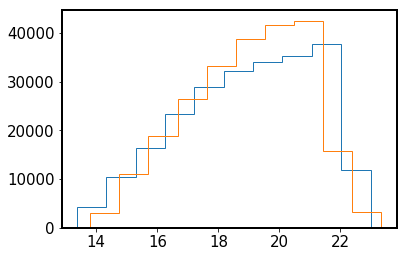

In [62]:
# plot the histogram 
plt.hist(lsst_gr['lsst_mag_g'], histtype='step')
plt.hist(lsst_gr['lsst_mag_r'], histtype='step')

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


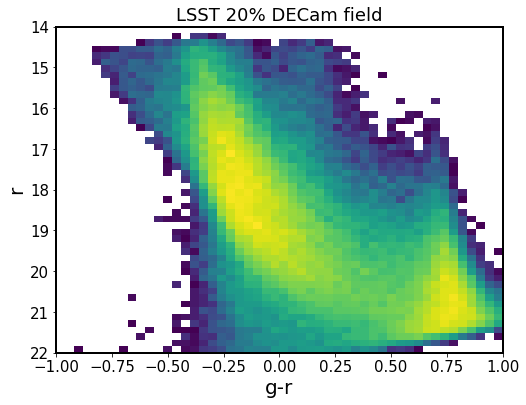

In [78]:
import matplotlib.colors as colors 
%matplotlib inline
g = lsst_gr['lsst_mag_g']
r = lsst_gr['lsst_mag_r']
fig,ax = plt.subplots(1,1, figsize=(8,6))
ax.hist2d(g-r,r, range=[[-1,1],[14,22]], cmin=10,
         norm = colors.LogNorm(), bins=50)
plt.gca().invert_yaxis()
ax.set_xlabel('g-r')
ax.set_ylabel('r')
ax.set_title('LSST 20% DECam field')

Makes sense (cf. Sesar+2010 Fig.23 http://faculty.washington.edu/ivezic/Publications/apj_708_1_717.pdf)

Color by a third variable, eg. mean photometric error:
    

In [79]:
lsst_gr.colnames

['lsst_mag_g',
 'lsst_magerr_g',
 'ra_lsst_g',
 'dec_lsst_g',
 'lsst_mag_r',
 'lsst_magerr_r',
 'ra_lsst_r',
 'dec_lsst_r']

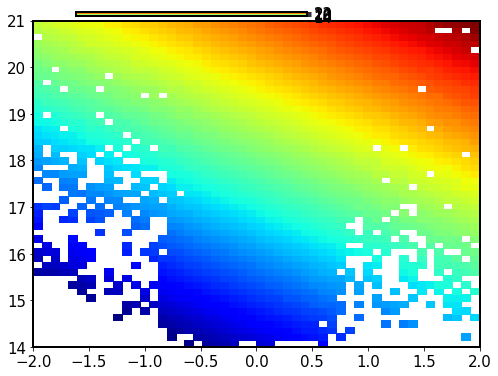

In [84]:
from scipy.stats import binned_statistic_2d
fig,ax = plt.subplots(figsize=(8,6))

x = g-r
y = r
z = g

xmin,xmax = -2,2
ymin,ymax = 14,21
mx = (xmin<x)*(x<xmax) 
my = (ymin<y)*(y<ymax)
m = mx*my
stats = binned_statistic_2d(x[m], y[m], values = z[m], statistic='mean', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0 
z_reduce  =  z_sigma # [:-1, :-1] no need to reduce here because x_edges are already given with the right size 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

# Plot 2D histogram using pcolor
image = ax.pcolormesh(x_edges,y_edges,z_masked, cmap='jet')  # np.log10(z_masked) gives log counts 

# add a colorbar  : define cax : colorbar axis 
colorbar_ax = fig.add_axes([0.2, 0.89, 0.4, 0.01])     #  (x0 ,y0  , dx,  dy )  
colorbar = fig.colorbar(image, cax = colorbar_ax,  orientation='vertical')